### This notebook concatenates 10 blocks (0-9) of hhblock data

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 1. Load and Concatenate Block Files

Load blocks 0-9 from the half-hourly dataset and concatenate into a single DataFrame.

In [6]:
# Load all block files
DATA_DIR = Path("../data/raw")

block_files = [DATA_DIR / f"block_{i}.csv" for i in range(10)]

# Check all files exist
missing = [f for f in block_files if not f.exists()]
if missing:
    print(f"Missing files: {missing}")
else:
    print(f"All {len(block_files)} block files found")

# Load and concatenate
dfs = []
for f in block_files:
    print(f"Loading {f.name}...")
    df = pd.read_csv(f)
    dfs.append(df)

hh = pd.concat(dfs, ignore_index=True)

print(f"\nConcatenated shape: {hh.shape}")
print(f"Unique households: {hh['LCLid'].nunique()}")
print(f"Date range: {hh['day'].min()} to {hh['day'].max()}")
hh.head()

All 10 block files found
Loading block_0.csv...
Loading block_1.csv...
Loading block_2.csv...
Loading block_3.csv...
Loading block_4.csv...
Loading block_5.csv...
Loading block_6.csv...
Loading block_7.csv...
Loading block_8.csv...
Loading block_9.csv...

Concatenated shape: (300147, 50)
Unique households: 499
Date range: 2011-11-29 to 2014-02-27


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## 2. Parse Dates and Add Weekday/Weekend Flag

In [7]:
# Parse dates and add temporal features
hh['date'] = pd.to_datetime(hh['day'], errors='coerce')
hh['weekday'] = hh['date'].dt.weekday
hh['is_weekend'] = (hh['weekday'] >= 5).astype(int)
hh['month'] = hh['date'].dt.month
hh['year'] = hh['date'].dt.year

# Drop rows with invalid dates
hh = hh.dropna(subset=['date'])

print(f"Shape after date parsing: {hh.shape}")
print(f"\nWeekday distribution:")
print(hh['weekday'].value_counts().sort_index())
print(f"\nWeekend vs Weekday:")
print(hh['is_weekend'].value_counts())
hh[['LCLid', 'date', 'weekday', 'is_weekend']].head(10)

Shape after date parsing: (300147, 55)

Weekday distribution:
weekday
0    42860
1    42887
2    43009
3    42958
4    42663
5    42887
6    42883
Name: count, dtype: int64

Weekend vs Weekday:
is_weekend
0    214377
1     85770
Name: count, dtype: int64


,LCLid,date,weekday,is_weekend
0,MAC000002,2012-10-13,5,1
1,MAC000002,2012-10-14,6,1
2,MAC000002,2012-10-15,0,0
3,MAC000002,2012-10-16,1,0
4,MAC000002,2012-10-17,2,0
5,MAC000002,2012-10-18,3,0
6,MAC000002,2012-10-19,4,0
7,MAC000002,2012-10-20,5,1
8,MAC000002,2012-10-21,6,1
9,MAC000002,2012-10-22,0,0


## 3. Prepare Half-Hourly Features for PCA

Extract the 48 half-hourly consumption values (hh_0 to hh_47) as features for each day.

In [8]:
# Get the 48 half-hourly columns
hh_cols = [f'hh_{i}' for i in range(48)]

# Check if all columns exist
missing_cols = [col for col in hh_cols if col not in hh.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
else:
    print("All 48 half-hourly columns found")

# Convert to numeric and handle missing values
for col in hh_cols:
    hh[col] = pd.to_numeric(hh[col], errors='coerce')

# Extract the feature matrix (each row = one day for one household)
X = hh[hh_cols].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Missing values before cleanup: {np.isnan(X).sum()}")

# Handle missing values - drop rows with any NaN in the half-hourly data
valid_rows = ~np.isnan(X).any(axis=1)
hh_clean = hh[valid_rows].copy()
X_clean = hh_clean[hh_cols].values

print(f"Shape after removing rows with missing values: {X_clean.shape}")
print(f"Remaining households: {hh_clean['LCLid'].nunique()}")
print(f"Missing values after cleanup: {np.isnan(X_clean).sum()}")

All 48 half-hourly columns found

Feature matrix shape: (300147, 48)
Missing values before cleanup: 481
Shape after removing rows with missing values: (299666, 48)
Remaining households: 499
Missing values after cleanup: 0


## 4. Standardize and Apply PCA

Standardize the 48-dimensional feature space and reduce dimensionality with PCA.

In [9]:
# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"Mean of scaled features: {X_scaled.mean():.6f}")
print(f"Std of scaled features: {X_scaled.std():.6f}")

Scaled feature matrix shape: (299666, 48)
Mean of scaled features: -0.000000
Std of scaled features: 1.000000


In [10]:
# Fit PCA with up to 20 components
n_components = min(20, X_scaled.shape[1], X_scaled.shape[0])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA output shape: {X_pca.shape}")
print(f"\nExplained variance ratio (first 10 components):")
for i, var in enumerate(pca.explained_variance_ratio_[:10]):
    cumsum = pca.explained_variance_ratio_[:i+1].sum()
    print(f"  PC{i+1}: {var:.4f} (cumulative: {cumsum:.4f})")

PCA output shape: (299666, 20)

Explained variance ratio (first 10 components):
  PC1: 0.5614 (cumulative: 0.5614)
  PC2: 0.0785 (cumulative: 0.6398)
  PC3: 0.0498 (cumulative: 0.6897)
  PC4: 0.0401 (cumulative: 0.7298)
  PC5: 0.0310 (cumulative: 0.7608)
  PC6: 0.0197 (cumulative: 0.7804)
  PC7: 0.0190 (cumulative: 0.7994)
  PC8: 0.0152 (cumulative: 0.8146)
  PC9: 0.0140 (cumulative: 0.8286)
  PC10: 0.0119 (cumulative: 0.8405)


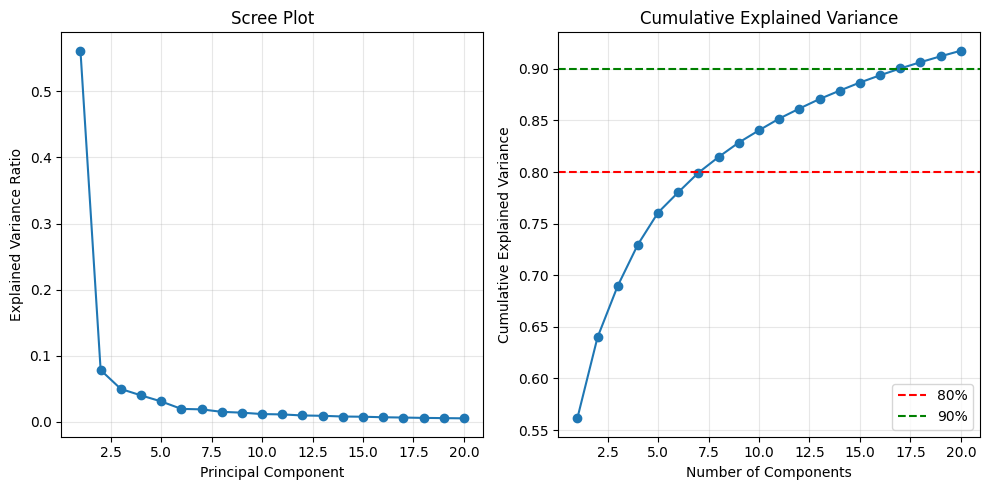

In [11]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80%')
plt.axhline(y=0.9, color='g', linestyle='--', label='90%')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Interpret Principal Components

Visualize the loadings to understand what each PC represents in terms of time-of-day patterns.

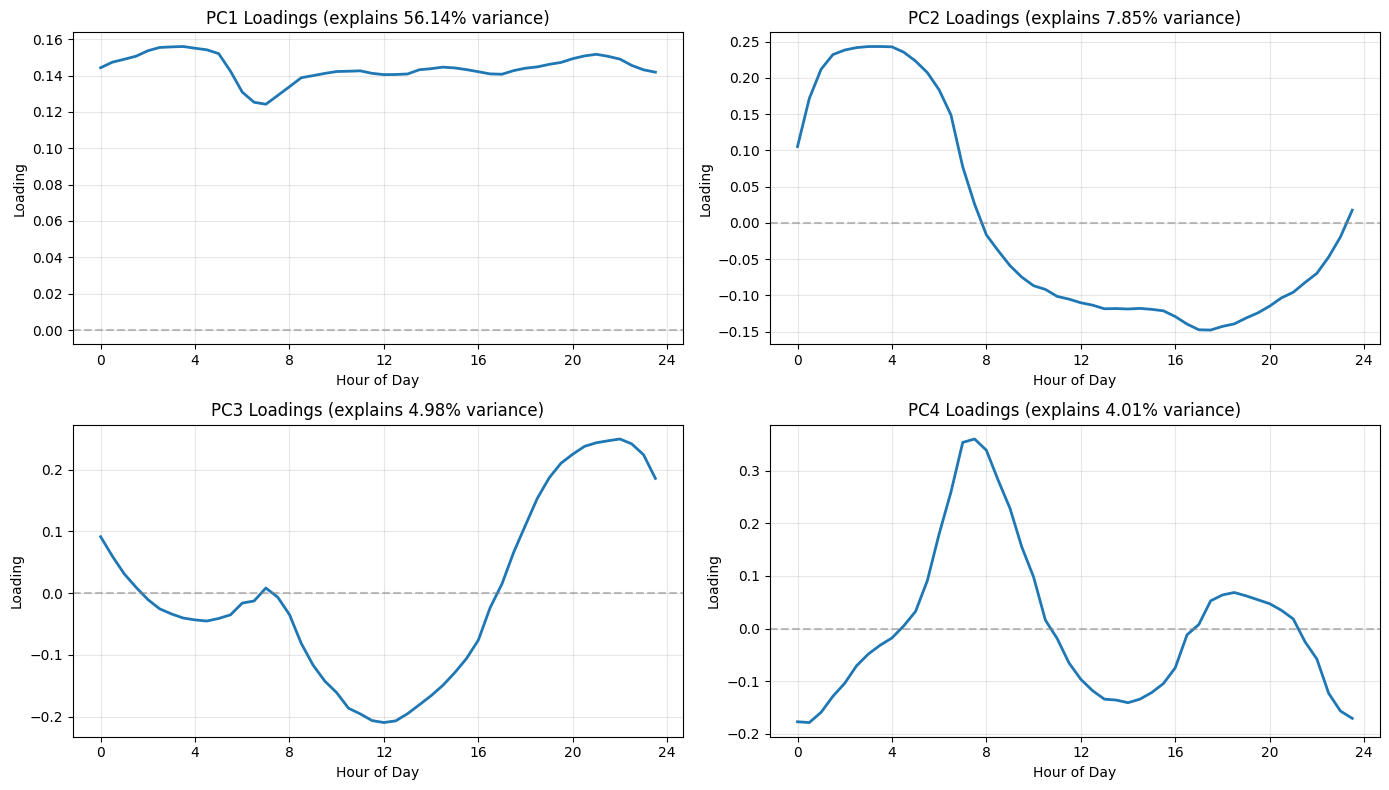

Interpretation guide:
- Positive loadings = higher consumption at those times increases this PC score
- Negative loadings = higher consumption at those times decreases this PC score


In [12]:
# Visualize the loadings for the first 4 PCs as time-of-day curves
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

hours = np.arange(0, 24, 0.5)  # 48 half-hour periods

for i in range(4):
    ax = axes[i]
    loadings = pca.components_[i, :]

    ax.plot(hours, loadings, linewidth=2)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Loading')
    ax.set_title(f'PC{i+1} Loadings (explains {pca.explained_variance_ratio_[i]:.2%} variance)')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 25, 4))

plt.tight_layout()
plt.show()

print("Interpretation guide:")
print("- Positive loadings = higher consumption at those times increases this PC score")
print("- Negative loadings = higher consumption at those times decreases this PC score")

In [13]:
# Attach PC scores to the dataframe
for i in range(min(10, X_pca.shape[1])):
    hh_clean[f'PC{i+1}'] = X_pca[:, i]

print("PC scores added to dataframe")
hh_clean[['LCLid', 'date', 'is_weekend', 'PC1', 'PC2', 'PC3', 'PC4']].head(10)

PC scores added to dataframe


,LCLid,date,is_weekend,PC1,PC2,PC3,PC4
0,MAC000002,2012-10-13,1,-1.240429,0.819532,-0.216647,-0.375935
1,MAC000002,2012-10-14,1,-0.926984,-0.670612,1.405878,-0.069629
2,MAC000002,2012-10-15,0,-1.860905,-0.069093,0.333415,0.362325
3,MAC000002,2012-10-16,0,-1.959889,0.092517,-0.325025,-0.594674
4,MAC000002,2012-10-17,0,-1.490454,-0.036138,-1.114618,-0.274271
5,MAC000002,2012-10-18,0,-1.437183,0.804820,0.682873,-0.267863
6,MAC000002,2012-10-19,0,-2.406515,0.450888,0.506967,-0.261086
7,MAC000002,2012-10-20,1,0.611973,-1.473362,0.817354,-1.165195
8,MAC000002,2012-10-21,1,3.656115,-0.419142,1.051930,-0.629531
9,MAC000002,2012-10-22,0,2.212270,2.585746,0.250311,1.190636


## 6. KMeans Clustering

Apply KMeans clustering on the principal components to identify distinct day types.

Clustering on first 5 PCs
Variance explained by first 5 PCs: 76.08%
k=2: silhouette=0.6713, inertia=6273960
k=3: silhouette=0.4693, inertia=4566601
k=4: silhouette=0.3598, inertia=3899528
k=5: silhouette=0.3299, inertia=3520791
k=6: silhouette=0.3247, inertia=3300541
k=7: silhouette=0.3068, inertia=3097793
k=8: silhouette=0.2675, inertia=2921364
k=9: silhouette=0.2703, inertia=2757456
k=10: silhouette=0.2604, inertia=2642762


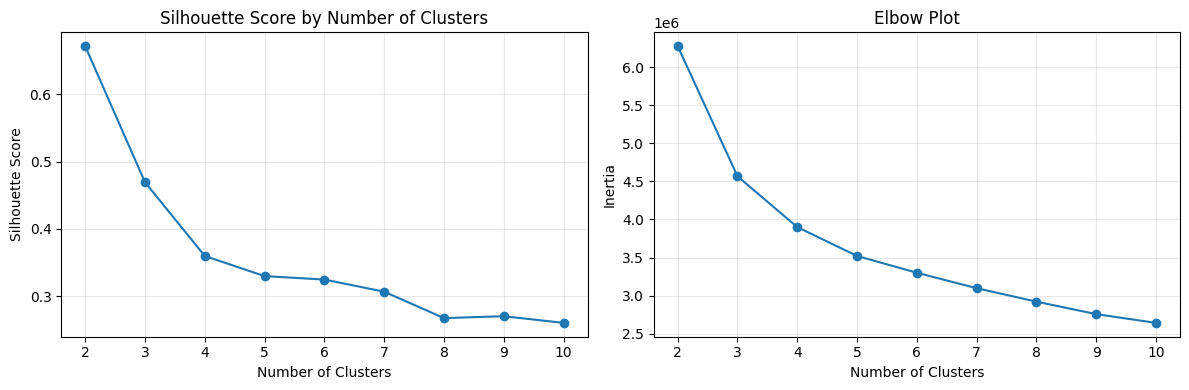


Best k by silhouette score: 2 (score: 0.6713)


In [16]:
# Determine optimal number of clusters using silhouette score
# Use first N principal components that explain ~80-90% of variance

# Let's use the first 5 PCs
n_pcs = 5
X_cluster = X_pca[:, :n_pcs]

print(f"Clustering on first {n_pcs} PCs")
print(f"Variance explained by first {n_pcs} PCs: {pca.explained_variance_ratio_[:n_pcs].sum():.2%}")

# Test different numbers of clusters
silhouette_scores = {}
inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    silhouette_scores[k] = silhouette_score(X_cluster, labels)
    inertias[k] = kmeans.inertia_
    print(f"k={k}: silhouette={silhouette_scores[k]:.4f}, inertia={inertias[k]:.0f}")

# Plot metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score by Number of Clusters')
axes[0].grid(True, alpha=0.3)

axes[1].plot(list(inertias.keys()), list(inertias.values()), marker='o')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Elbow Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nBest k by silhouette score: {best_k} (score: {silhouette_scores[best_k]:.4f})")

In [21]:
# Fit final clustering model
# You can manually set K here based on the plots above
K = best_k  # or manually set like: K = 4

print(f"Fitting KMeans with K={K} clusters...")
kmeans_final = KMeans(n_clusters=K, random_state=42, n_init=20)
hh_clean['cluster'] = kmeans_final.fit_predict(X_cluster)

print(f"\nCluster distribution:")
print(hh_clean['cluster'].value_counts().sort_index())

print(f"\nCluster distribution by weekend/weekday:")
print(pd.crosstab(hh_clean['cluster'], hh_clean['is_weekend'], normalize='columns'))

Fitting KMeans with K=2 clusters...

Cluster distribution:
cluster
0    273733
1     25933
Name: count, dtype: int64

Cluster distribution by weekend/weekday:
is_weekend        0         1
cluster                      
0           0.91552  0.908325
1           0.08448  0.091675


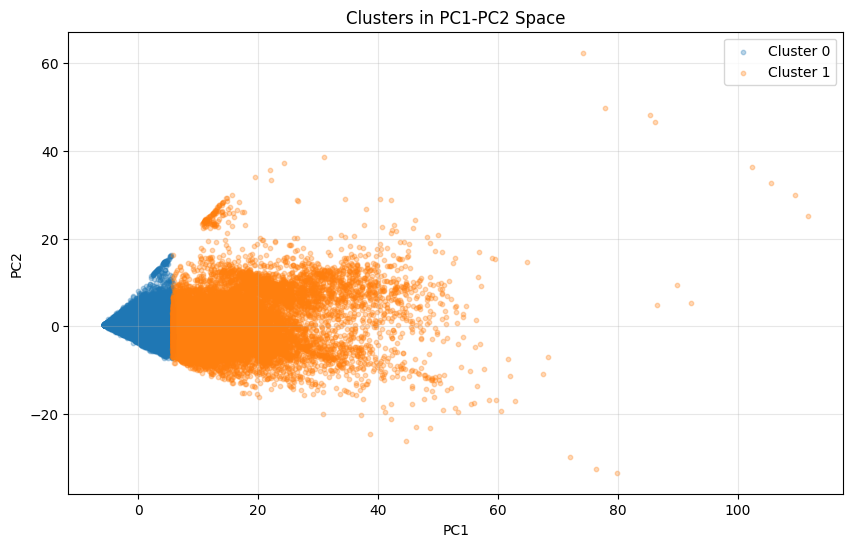

In [22]:
# Visualize clusters in PC1-PC2 space
plt.figure(figsize=(10, 6))
for cluster in sorted(hh_clean['cluster'].unique()):
    subset = hh_clean[hh_clean['cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'],
                alpha=0.3, s=10, label=f'Cluster {cluster}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters in PC1-PC2 Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Interpret Clusters - Average Consumption Profiles

Visualize the average half-hourly consumption pattern for each cluster to understand what makes them distinct.

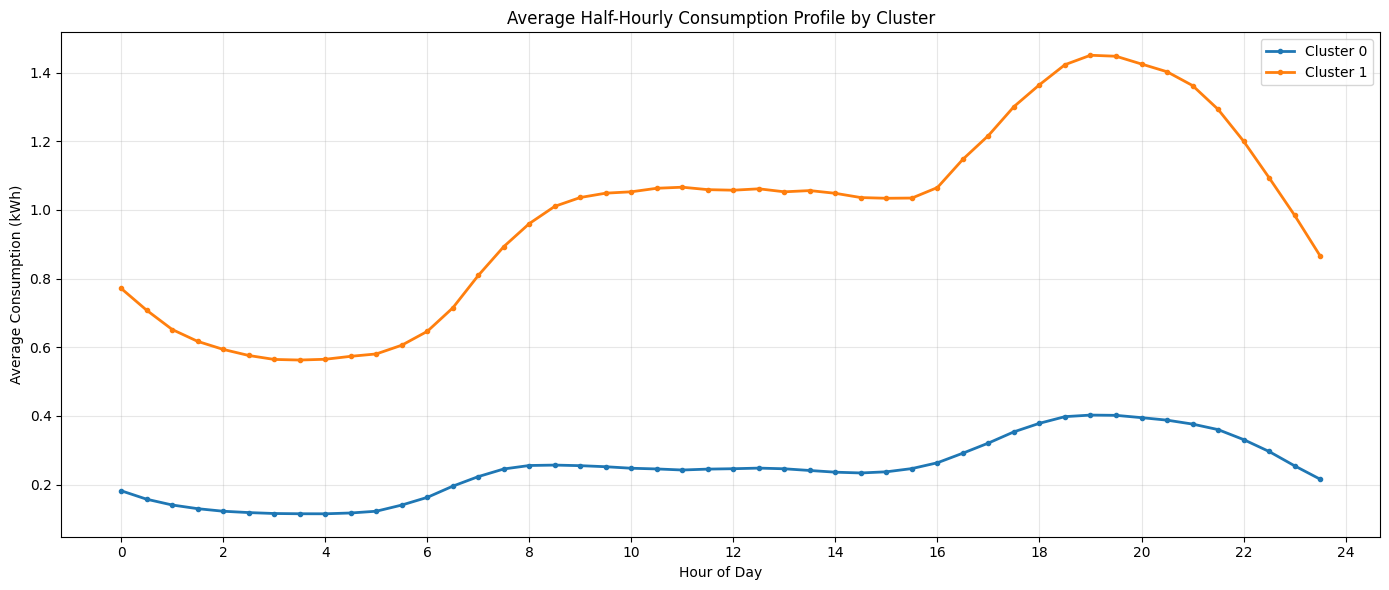

Cluster Statistics:

Cluster 0:
  Days: 273733 (91.3%)
  Unique households: 496
  Avg daily consumption: 11.76 kWh
  Weekend days: 28.5%

Cluster 1:
  Days: 25933 (8.7%)
  Unique households: 263
  Avg daily consumption: 47.15 kWh
  Weekend days: 30.3%


In [23]:
# Calculate average consumption profile for each cluster
cluster_profiles = []
hours = np.arange(0, 24, 0.5)

for cluster in sorted(hh_clean['cluster'].unique()):
    cluster_data = hh_clean[hh_clean['cluster'] == cluster]
    avg_profile = cluster_data[hh_cols].mean().values
    cluster_profiles.append(avg_profile)

# Plot all cluster profiles
plt.figure(figsize=(14, 6))

for i, profile in enumerate(cluster_profiles):
    plt.plot(hours, profile, linewidth=2, label=f'Cluster {i}', marker='o', markersize=3)

plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Average Half-Hourly Consumption Profile by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 25, 2))
plt.tight_layout()
plt.show()

# Print cluster statistics
print("Cluster Statistics:")
for cluster in sorted(hh_clean['cluster'].unique()):
    cluster_data = hh_clean[hh_clean['cluster'] == cluster]
    avg_daily = cluster_data[hh_cols].sum(axis=1).mean()
    pct_weekend = cluster_data['is_weekend'].mean() * 100
    n_days = len(cluster_data)
    n_households = cluster_data['LCLid'].nunique()

    print(f"\nCluster {cluster}:")
    print(f"  Days: {n_days} ({n_days/len(hh_clean)*100:.1f}%)")
    print(f"  Unique households: {n_households}")
    print(f"  Avg daily consumption: {avg_daily:.2f} kWh")
    print(f"  Weekend days: {pct_weekend:.1f}%")

## 8. Household Profiles - Distribution Across Day Types

Aggregate back to household level: what proportion of each household's days fall into each cluster?

In [24]:
# Create household-level cluster distribution
household_cluster_dist = hh_clean.groupby(['LCLid', 'cluster']).size().unstack(fill_value=0)

# Convert to proportions
household_cluster_pct = household_cluster_dist.div(household_cluster_dist.sum(axis=1), axis=0)

print("Household cluster distribution (proportions):")
print(household_cluster_pct.head(10))

# Find the dominant cluster for each household
household_cluster_pct['dominant_cluster'] = household_cluster_pct.idxmax(axis=1)
household_cluster_pct['dominant_cluster_pct'] = household_cluster_pct.max(axis=1)

print("\nDominant cluster distribution:")
print(household_cluster_pct['dominant_cluster'].value_counts().sort_index())

print("\nAverage dominance (how much of a household's days are in their dominant cluster):")
print(f"{household_cluster_pct['dominant_cluster_pct'].mean():.2%}")

Household cluster distribution (proportions):
cluster           0         1
LCLid                        
MAC000002  0.991952  0.008048
MAC000005  1.000000  0.000000
MAC000017  1.000000  0.000000
MAC000026  0.991315  0.008685
MAC000030  0.990099  0.009901
MAC000040  0.559259  0.440741
MAC000050  0.886410  0.113590
MAC000052  0.998758  0.001242
MAC000063  0.996928  0.003072
MAC000073  1.000000  0.000000

Dominant cluster distribution:
dominant_cluster
0    466
1     33
Name: count, dtype: int64

Average dominance (how much of a household's days are in their dominant cluster):
96.14%


## 9. Save Results

Save the concatenated data with cluster assignments for further analysis.

In [25]:
# Save the concatenated data with cluster assignments
output_path = Path("../data/processed/10_blocks_HH_clustered.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)

hh_clean.to_csv(output_path, index=False)
print(f"Saved clustered data to: {output_path}")
print(f"Shape: {hh_clean.shape}")

# Also save household-level cluster distribution
household_output_path = Path("../data/processed/household_cluster_distribution.csv")
household_cluster_pct.to_csv(household_output_path)
print(f"\nSaved household cluster distribution to: {household_output_path}")
print(f"Shape: {household_cluster_pct.shape}")

Saved clustered data to: ../data/processed/10_blocks_HH_clustered.csv
Shape: (299666, 66)

Saved household cluster distribution to: ../data/processed/household_cluster_distribution.csv
Shape: (499, 4)
